# Clustering


## Initial Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi # to find GPU memory => use 90 to 95% of memory. minibatch size to power of 2
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May  2 13:17:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install transformers
!pip install datasets
from transformers import AutoTokenizer, AutoModelForMaskedLM, pipeline, DataCollatorForLanguageModeling, Trainer, TrainingArguments,LineByLineTextDataset
import transformers
from datasets import Dataset
import shutil
import os

     |████████████████████████████████| 4.0 MB 32.8 MB/s 
     |████████████████████████████████| 895 kB 85.1 MB/s 
     |████████████████████████████████| 596 kB 73.7 MB/s 
     |████████████████████████████████| 6.6 MB 72.2 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 325 kB 32.5 MB/s 
     |████████████████████████████████| 212 kB 69.9 MB/s 
     |████████████████████████████████| 136 kB 48.9 MB/s 
     |████████████████████████████████| 1.1 MB 64.5 MB/s 
     |████████████████████████████████| 127 kB 78.6 MB/s 
     |████████████████████████████████| 271 kB 71.5 MB/s 
     |████████████████████████████████| 144 kB 90.9 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urll

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz
import en_core_sci_lg
import spacy
spacy.prefer_gpu()
from spacy.lang.en.stop_words import STOP_WORDS  

     |████████████████████████████████| 538.1 MB 5.4 kB/s 
     |████████████████████████████████| 5.8 MB 10.2 MB/s 
     |████████████████████████████████| 457 kB 72.6 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 653 kB 70.4 MB/s 
     |████████████████████████████████| 10.1 MB 75.0 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
  Created wheel for en-core-sci-lg: filename=en_core_sci_lg-0.4.0-py3-none-any.whl size=538899689 sha256=5ace2c88266bf91dcd800d8f02c4c021a25e2e75d06e98a97d17d5c3288e25bc
  Stored in directory: /root/.cache/pip/wheels/87/6f/e6/a51909709009e9a36e5385cff94257a7fc036ff2f9670e71f8
Successfully built en-core-sci-lg
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Un

In [ ]:
!pip install umap-learn
from umap import UMAP

     |████████████████████████████████| 88 kB 3.5 MB/s 
     |████████████████████████████████| 1.1 MB 36.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=765bbaca37caed79716e0cfa0c85f5b5544331e62e35bc4d33ed11b02ae97006
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=60a46dafc65e78fe5b33b8b287c5aa4724a9e7f176519c769e43461e871bd4fd
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [4]:
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import json
import pandas as pd
import numpy as np
from scipy import sparse 
from pandas.api.types import CategoricalDtype 
from tqdm import tqdm, trange
from IPython.utils import io
import string
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
#import plotly.express as px
import torch.nn as nn
import torch 
import altair as alt
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from torch.optim import Adam
from collections import Counter
from sklearn.preprocessing import normalize
#import plotly.express as px
import gensim
import scipy
import pickle

import io
import os
import math
import copy
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

import requests

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Pickle files into DataFrames

In [ ]:
interaction_df = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/interaction_df.pickle")
print("interaction_df length: " + str(len(interaction_df)))
interaction_df.head()

interaction_df length: 2894399


document                author
0  0704.0479             T.Geisser
1  0704.1445        Yasha Gindikin
1  0704.1445  Vladimir A. Sablikov
2  0705.0033  Nikos Frantzikinakis
2  0705.0033    Randall McCutcheon

In [ ]:
trimmed_cleaned_df = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/trimmed_cleaned_arxiv_docs.pickle")
print("trimmed_cleaned_df length: " + str(len(trimmed_cleaned_df)))
trimmed_cleaned_df.head()

trimmed_cleaned_df length: 581780


id                                       authors  \
0  0704.0479                                     T.Geisser   
1  0704.1445       Yasha Gindikin and Vladimir A. Sablikov   
2  0705.0033      Nikos Frantzikinakis, Randall McCutcheon   
3  0705.0344                                 J. P. Pridham   
4  0705.0825  Ram Gopal Vishwakarma (Zacatecas University)   

                                               title  \
0               The affine part of the Picard scheme   
1  Deformed Wigner crystal in a one-dimensional q...   
2                         Ergodic Theory: Recurrence   
3              Unifying derived deformation theories   
4  Einstein's Theory of Gravity in the Presence o...   

                          doi                              category  \
0                        None                    [math.AG, math.KT]   
1  10.1103/PhysRevB.76.045122  [cond-mat.str-el, cond-mat.mes-hall]   
2                        None                             [math.DS]   
3                        None                             [math.AG]   
4   10.1007/s10509-009-0016-8             [gr-qc, astro-ph, hep-th]   

                                            abstract  abstract_word_count  \
0    We describe the maximal torus and maximal un...                   21   
1    The spatial Fourier spectrum of the electron...                  168   
2    We survey the impact of the Poincar\'e recur...                   22   
3    We develop a framework for derived deformati...                   87   
4    The mysterious `dark energy' needed to expla...                   83   

                                    authors_split  
0                                     [T.Geisser]  
1          [Yasha Gindikin, Vladimir A. Sablikov]  
2      [Nikos Frantzikinakis, Randall McCutcheon]  
3                                 [J. P. Pridham]  
4  [Ram Gopal Vishwakarma (Zacatecas University)]

In [ ]:
interaction_sparse = scipy.sparse.load_npz("./drive/MyDrive/Colab Notebooks/CE/data/interaction_sparse.npz")

idx2auth=[]
with open("./drive/MyDrive/Colab Notebooks/CE/data/idx2auth.pickle", "rb") as fp:
  idx2auth = pickle.load(fp)


idx2doc=[]
with open("./drive/MyDrive/Colab Notebooks/CE/data/idx2doc.pickle", "rb") as fp:
  idx2doc = pickle.load(fp)

print("type of sparse matrix: " + str(type(interaction_sparse)))
print("\nShape of sparse matrix: " + str(interaction_sparse.shape))
print("\nnonzero entries of sparse matrix: ")
print("    rows or people:       " + str(interaction_sparse.nonzero()[0]))
print("    columns or documents: " + str(interaction_sparse.nonzero()[1]))

print("\nidx2auth length: " + str(len(idx2auth)))

print("\nidx2doc length: " + str(len(idx2doc)))

type of sparse matrix: <class 'scipy.sparse.csr.csr_matrix'>

Shape of sparse matrix: (972506, 581780)

nonzero entries of sparse matrix: 
    rows or people:       [     0      1      2 ... 972503 972504 972505]
    columns or documents: [477657 343615 308634 ... 408477 271554 371810]

idx2auth length: 972506

idx2doc length: 581780


### Sparse Matrix Sanity Check

In [ ]:
print("type of sparse matrix: " + str(type(interaction_sparse)))
print("\nShape of sparse matrix: " + str(interaction_sparse.shape))
print("\nnonzero entries of sparse matrix: ")
print("    rows or people:       " + str(interaction_sparse.nonzero()[0]))
print("    columns or documents: " + str(interaction_sparse.nonzero()[1]))

type of sparse matrix: <class 'scipy.sparse.csr.csr_matrix'>

Shape of sparse matrix: (972506, 581780)

nonzero entries of sparse matrix: 
    rows or people:       [     0      1      2 ... 972503 972504 972505]
    columns or documents: [477657 343615 308634 ... 408477 271554 371810]


In [ ]:
def getNonZeroByIndex(sparse_m, idx, printOutput=False):
  nonzero_values = sparse_m.nonzero()
  author_index = nonzero_values[0][idx]
  document_index = nonzero_values[1][idx]
  interaction_value = sparse_m[author_index, document_index]
  if printOutput:
    print("\n======================== Get Non Zero Entry by Index ========================")
    print("index in sparse matrix storage: " + str(idx))
    print("author index: " + str(author_index))
    print("document index: " + str(document_index))
    print("interaction value: " + str(interaction_value))
  return author_index, document_index, interaction_value

What does everything hold:
  * `interaction_sparse.nonzero()` holds `(row_index, col_index)` tuples where  `interaction_sparse[row_index, col_index]==1`
  * `idx2doc` allows you to get document ids with `idx2doc[col_index]`. Therefore `idx2doc` is ordered the same as columns of the sparse matrix.
  * `idx2auth` allows you to get document ids with `idx2auth[row_index]`. Therefore `idx2auth` is ordered the same as rows of the sparse matrix.
  * `trimmed_cleaned_df` holds all the document information in the same order as both the columns of `interaction_sparse` and `idx2doc`

In [ ]:
auth_idx, doc_idx, interaction_val = getNonZeroByIndex(sparse_m=interaction_sparse, idx=52244, printOutput=True)

print("\nauthor: " + idx2auth[auth_idx])
print("document: " + idx2doc[doc_idx])

print("\ndocument title: " + trimmed_cleaned_df.loc[trimmed_cleaned_df['id'] == idx2doc[doc_idx]]['title'].tolist()[0] + "\n")

print(trimmed_cleaned_df.iloc[doc_idx])
print("\n")

interaction_df.loc[interaction_df['document'] == idx2doc[doc_idx]]


======================== Get Non Zero Entry by Index ========================
index in sparse matrix storage: 52244
author index: 24754
document index: 46129
interaction value: 1

author: A. E. Bondar
document: 1812.09018

document title: COMET Phase-I Technical Design Report

id                                                            1812.09018
authors                The COMET Collaboration: R. Abramishvili, G. A...
title                              COMET Phase-I Technical Design Report
doi                                                  10.1093/ptep/ptz125
category                                       [physics.ins-det, hep-ex]
abstract                 The Technical Design for the COMET Phase-I e...
abstract_word_count                                                  153
authors_split          [The COMET Collaboration: R. Abramishvili, G. ...
Name: 46132, dtype: object




document                                    author
46132  1812.09018  The COMET Collaboration: R. Abramishvili
46132  1812.09018                                 G. Adamov
46132  1812.09018             R. R. Akhmetshin,\n  A. Allin
46132  1812.09018                         J. C. Ang\'elique
46132  1812.09018                              V. Anishchik
...           ...                                       ...
46132  1812.09018                              Yu. V. Yudin
46132  1812.09018                           M. V. Zdorovets
46132  1812.09018                                  J. Zhang
46132  1812.09018                                  Y. Zhang
46132  1812.09018                               K.\n  Zuber

[189 rows x 2 columns]

## Tokenize (documents_with_tokens.pickle)

In [ ]:
trimmed_cleaned_df = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/trimmed_cleaned_arxiv_docs.pickle")

In [ ]:
cats = trimmed_cleaned_df['category'].explode()
cats.value_counts()[:50]

hep-ph                121335
hep-th                115458
quant-ph               83288
astro-ph               80515
gr-qc                  70486
cond-mat.mes-hall      62940
cond-mat.mtrl-sci      54816
cond-mat.str-el        53338
cond-mat.stat-mech     50408
astro-ph.CO            49046
astro-ph.GA            44531
astro-ph.SR            43041
nucl-th                40487
astro-ph.HE            37319
math-ph                36753
math.MP                36753
hep-ex                 31545
cond-mat.supr-con      31337
cond-mat.soft          25018
physics.optics         24911
astro-ph.EP            19392
hep-lat                17806
nucl-ex                17338
cond-mat.dis-nn        15980
astro-ph.IM            15235
cond-mat.quant-gas     15131
physics.atom-ph        14654
physics.flu-dyn        13058
cs.LG                  12526
physics.chem-ph        11506
cond-mat               11204
cond-mat.other         11184
math.AP                11116
math.PR                11053
physics.comp-p

In [ ]:
category = "cs.LG"

cats = trimmed_cleaned_df['category'].explode()
keys = [k for k, v in cats.items() if v == category]
keys = list(set(keys))
trimmed_cleaned_df = trimmed_cleaned_df.loc[keys].sort_index().reset_index()

In [ ]:
trimmed_cleaned_df.head(5)

index         id                                            authors  \
0    434  0704.0671                                   [Raginsky Maxim]   
1    628  0704.0954                    [Kar Soummya, Moura Jose M. F.]   
2   4042  0705.2318       [Utsumi Hideto, Miyoshi Seiji, Okada Masato]   
3   5911  0706.0585  [Zhao Zhendong, Yuan Lei, Wang Yuxuan, Bao For...   
4   6779  0706.2040                                [Airoldi Edoardo M]   

                                               title  \
0              Learning from compressed observations   
1  Sensor Networks with Random Links: Topology De...   
2  Statistical Mechanics of Nonlinear On-line Lea...   
3  A Novel Model of Working Set Selection for SMO...   
4  Getting started in probabilistic graphical models   

                            doi  \
0      10.1109/ITW.2007.4313111   
1       10.1109/TSP.2008.920143   
2        10.1143/JPSJ.76.114001   
3         10.1109/ICTAI.2007.99   
4  10.1371/journal.pcbi.0030252   

                                            category  \
0                            [cs.IT, cs.LG, math.IT]   
1                            [cs.IT, cs.LG, math.IT]   
2                           [cs.LG, cond-mat.dis-nn]   
3                                     [cs.LG, cs.AI]   
4  [q-bio.QM, cs.LG, physics.soc-ph, stat.ME, sta...   

                                            abstract  
0    The problem of statistical learning is to co...  
1    In a sensor network, in practice, the commun...  
2    We analyze the generalization performance of...  
3    In the process of training Support Vector Ma...  
4    Probabilistic graphical models (PGMs) have b...

In [ ]:
#df_clustering = trimed_cleaned_df.sample(10000, random_state=42).reset_index()
documents_to_tokenize=trimmed_cleaned_df

### Spacy

In [ ]:
parser = en_core_sci_lg.load()
parser.max_length = 7000000

In [ ]:
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens_split = mytokens
    mytokens = " ".join([i for i in mytokens]) 
    return (mytokens, mytokens_split)

In [ ]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['keep',
 'nor',
 'him',
 'but',
 'whether',
 'cannot',
 '’m',
 'i',
 'really',
 'nothing']

In [ ]:
tqdm.pandas()
retVal = documents_to_tokenize["abstract"].progress_apply(spacy_tokenizer)

100%|██████████| 12526/12526 [07:22<00:00, 28.28it/s]


In [ ]:
df=pd.DataFrame(retVal.tolist())
df.columns=['processed_text', 'tokens_split']
documents_to_tokenize["processed_text"] = df['processed_text']
documents_to_tokenize["tokens_split"] = df["tokens_split"]

### Save documents_with_tokens.pickle

In [ ]:
documents_to_tokenize.to_pickle("/content/drive/MyDrive/Colab Notebooks/CE/data/hasDOI/documents_with_tokens_split_cs.LG.pickle")

In [ ]:
documents_with_tokens = documents_to_tokenize
documents_with_tokens.iloc[0:1]

index         id           authors                                  title  \
0    434  0704.0671  [Raginsky Maxim]  Learning from compressed observations   

                        doi                 category  \
0  10.1109/ITW.2007.4313111  [cs.IT, cs.LG, math.IT]   

                                            abstract  \
0    The problem of statistical learning is to co...   

                                      processed_text  \
0  problem statistical learning construct predict...   

                                        tokens_split  
0  [problem, statistical, learning, construct, pr...

## Kmeans Clustering

Her we take document embeddings and cluster them. It returns a numpy array that is the length of the number of documents embeddings passed into the function. So for 1024 embeddings, it should return an array of length 1024 containing the number of the cluster that embedding belonged to. Therefore, we must attach the cluster number back on to the original dataframe to connect the cluster number with the original data. [Scikit-learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [ ]:
def doKmeans(embeddings, k=20, printOutput=False):
  kmeans = KMeans(n_clusters=k, random_state=42)
  y_pred = kmeans.fit_predict(embeddings)
  if printOutput:
    print("\n======================== K-means Clustering ========================")
    print("Input shape: " + str(embeddings.shape))
    print("\nNumber Clusters: " + str(k))
    print("\nOutput size: " + str(len(y_pred)))
    print("\nOutput type: " + str(type(y_pred)))
    print("\nOutput: " + str(y_pred))
  return y_pred

## Dimension Reduction Functions

#### PCA Dimension Reduction

Here PCA is used to reduce the number of features from 4096 to something smaller. The number of documents remains the same which is why you should see the smae number of rows and a smaller number of columns (features). [Scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [ ]:
def doPCA(embeddings, printOutput=False, n_components=0.95):
  pca = PCA(n_components=.95, random_state=42) #Keep 95% of the variance
  embeddings_reduced = pca.fit_transform(embeddings.toarray())
  
  if printOutput:
    print("\n======================== PCA Dimension Reduction ========================")
    print("\nInput shape: " + str(embeddings.shape))
    print("\nOutput Shape: " + str(embeddings_reduced.shape))
    print("\nNumber of Documents: " + str(embeddings_reduced.shape[0]))
    print("\nNumber of Features: " + str(embeddings_reduced.shape[1]))
    print("\nData Type: " + str(type(embeddings_reduced)))
  return embeddings_reduced

#### UMAP Dimension Reduction

Performs dimension reduction using UMAP algorithm. [UMAP Documentation](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)

In [ ]:
def doUMAP(in_embeddings, printOutput=False):
  umap = UMAP(n_neighbors=100, min_dist=0.3, n_components=2)
  umap_embeddings = umap.fit_transform(in_embeddings)
  if printOutput:
    print("\n======================== Umap Dimension Reduction ========================")
    print("\nInput shape: " + str(in_embeddings.shape))
    print("\nOutput shape: " + str(umap_embeddings.shape))
    print("\nOutput type: " + str(type(umap_embeddings)))
    print("\nOutput: " + str(umap_embeddings))
  return umap_embeddings

#### TSNE Dimension Reduction

Performs TSNE Dimension Reduction. [Sciket-learn TSNE Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [ ]:
def doTSNE(in_embeddings, printOutput=False, verbose=0):
  tsne = TSNE(verbose=verbose, perplexity=100, random_state=42)
  tsne_embeddings = tsne.fit_transform(in_embeddings)
  if printOutput:
    print("\n======================== TSNE Dimension Reduction ========================")
    print("Input shape: " + str(in_embeddings.shape))
    print("\nOutput shape: " + str(tsne_embeddings.shape))
    print("\nOutput type: " + str(type(tsne_embeddings)))
    print("\nOutput: " + str(tsne_embeddings))
  return tsne_embeddings

## Plotting Functions

In [ ]:
def clusterPlot(embeddings, title, clusters=[], numClusters=1):
  sns.set(rc={'figure.figsize':(15,15)})
  if numClusters<=1:
    palette = sns.color_palette("bright", 1)
    sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], palette=palette)
  else:
    palette = sns.hls_palette(numClusters, l=.4, s=.9)
    sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=clusters, legend='full', palette=palette)
  plt.title(title)
  plt.show()

def interactiveClusterPlot(df, embeddings, title, clusters):
  fig = px.scatter(df, x=embeddings[:,0], y=embeddings[:,1], color=clusters.astype(str),
                 hover_data=['id', 'authors', 'title',],
                 height= 1000, width=1000,
                title = title)
  fig.show()

## Nearest Neighbor Function

In [8]:
def doNNeighbor(in_embeddings, sample_embeddings, n_neighbor=10, printOutput=False):
  nearNeighbor = NearestNeighbors(n_neighbors=n_neighbor,
                         metric='cosine',
                         algorithm='brute',
                         n_jobs=-1)
  nearNeighbor.fit(in_embeddings)
  _, near_idx = nearNeighbor.kneighbors(X=sample_embeddings, n_neighbors=n_neighbor, return_distance=True)
  if printOutput:
    print("\n======================== Nearest Neighbor ========================")
    print("\nInput shape: " + str(in_embeddings.shape))
    print("\nOutput shape: " + str(near_idx.shape))
    print("\nOutput type: " + str(type(near_idx)))
    print("\nOutput: " + str(near_idx))
  return near_idx

In [9]:
def createNNeighbor(in_embeddings, n_neighbor=10):
  nearNeighbor = NearestNeighbors(n_neighbors=n_neighbor,
                         metric='cosine',
                         algorithm='brute',
                         n_jobs=-1)
  nearNeighbor.fit(in_embeddings)
  return nearNeighbor

## Co-citation Functions

Find papers that cite the searched paper

In [ ]:
#citations = requests.get("https://w3id.org/oc/index/api/v1/citations/10.1103/PhysRevD.76.013009")
#print(json.dumps(citations.json(), indent=4))

Find papers referenced in the searched paper.

In [ ]:
#references = requests.get("https://w3id.org/oc/index/api/v1/references/10.1103/PhysRevD.76.013009")
#print(json.dumps(references.json(), indent=4))

In [10]:
def listDois(endpoint, doi_array):
  retArr=[0] * len(doi_array);
  for idx, doi in enumerate(doi_array):
    retArr[idx] = requests.get("https://w3id.org/oc/index/api/v1/" + endpoint + "/" + doi).json()
  return retArr

In [11]:
def listRecommendedCitations(doi_array):
  citObjects = listDois("citations", doi_array)
  return [set([cit["citing"][8:] for cit in paper]) for paper in citObjects]

def listCitationReferences(doi_array):
  refObjects = listDois("references", doi_array)
  return [set([ref["cited"][8:] for ref in paper]) for paper in refObjects]

In [12]:
def calculateCoCitations(doi, recommended_dois, printOutput=False):
  citations = requests.get("https://w3id.org/oc/index/api/v1/citations/" + doi).json()
  references = requests.get("https://w3id.org/oc/index/api/v1/references/" + doi).json()

  #if (printOutput):
  #  print(json.dumps(citations, indent=4))
  
  citation_dois = [citation["citing"][8:] for citation in citations]
  reference_dois = [reference["cited"][8:] for reference in references]

  coCitationCount = 0
  citedCount = 0
  refCount = 0
  recommended_dois_set = set(recommended_dois)
  for doi in citation_dois:
    if doi in recommended_dois_set:
      citedCount+=1
  
  for doi in reference_dois:
    if doi in recommended_dois_set:
      refCount+=1

  if len(citation_dois) < len(recommended_dois):
    # get a list of dois that have cited the recomended papers
    recommended_citation_dois = listRecommendedCitations(recommended_dois)
    for doi in citation_dois:
      for rec_doi_set in recommended_citation_dois:
        # check if any of the papers that cited our input doi (citation_dois) also cited the any of the recommended dois (recommended_citation_dois)
        if doi in rec_doi_set:
          coCitationCount+=1

  else:
    # get a list of references for each paper that has cited our input doi
    citation_references = listCitationReferences(citation_dois)
    for doi in recommended_dois:
      for citation_reference_set in citation_references:
        # check if our recommended dois (recommended_dois) are also used as references in the list of dois that have cited our input (citation_references)
        if doi in citation_reference_set:
          coCitationCount+=1 


  return { "coCitationCount": coCitationCount, "citedCount": citedCount, "refCount": refCount}
          

In [13]:
def coCitationScores(recommendations, printOutput=False):
  scores = [0] * len(recommendations)
  for idx, rec in enumerate(recommendations):
    #print(rec[:1][0])
    scores[idx] = calculateCoCitations(rec[:1][0], rec[1:], printOutput=printOutput)
    if (printOutput == True):
      print("\n======================= " + rec[:1][0] + " =======================")
      print(scores[idx])
  return scores

In [ ]:
# cited = "10.1103/physrevd.76.013009"
# citing = ["10.1140/epjc/s10052-021-09687-4","10.1007/jhep04(2021)041", "10.1103/physrevlett.95.022003", "10.1103/physrevlett.85.4678"] 

# print(calculateCoCitations(cited, citing))

{'coCitationCount': 14, 'citedCount': 2, 'refCount': 2}


In [14]:
def averageScores(scores, printOutput = False):
  coCitationCount = 0
  citedCount= 0
  refCount = 0
  n = len(scores)
  
  for score in scores:
    coCitationCount += score['coCitationCount']
    citedCount += score['citedCount']
    refCount += score['refCount']
  
  coCitationScore = coCitationCount/n
  citedScore = citedCount/n
  refScore = refCount/n
  
  if printOutput:
    print("\n\n==================== Recommender Scores (Averages) ====================")
    print("Co-citation Score: " + str(coCitationScore))
    print("Citation Score: " + str(citedScore))
    print("Reference Score: " + str(refScore))
    print("=======================================================================\n\n")

  return coCitationScore, citedScore, refScore

In [15]:
def multiSampleCoCitations(embeddings, documents, sample_size = 10, num_neighbors = 10, printOutput=False, seed=420):
  nearNeighbor = createNNeighbor(in_embeddings = embeddings, n_neighbor=10)

  number_of_rows = embeddings.shape[0]
  np.random.seed(seed)
  test_indeces = np.random.choice(number_of_rows, size=sample_size, replace=False)
  test_embeddings = embeddings[test_indeces, :]

  nearNeighbor = createNNeighbor(in_embeddings = embeddings, n_neighbor=10)
  _, nneighbors = nearNeighbor.kneighbors(X=test_embeddings, n_neighbors=num_neighbors, return_distance=True)
  nneighbors_dois = [documents.iloc[rec]['doi'].to_numpy() for rec in nneighbors]
  
  scores = coCitationScores(nneighbors_dois, printOutput=printOutput)

  cocitationScore, citedScore, refScore = averageScores(scores, printOutput = printOutput)

  return cocitationScore, citedScore, refScore

## TFIDF

In [ ]:
#documents_with_tokens = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/documents_with_tokens.pickle")
documents_with_tokens = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/documents_with_tokens_split_hep_th.pickle")

In [ ]:
print("length of documents_with_tokens: " + str(len(documents_with_tokens)))
documents_with_tokens.iloc[0:1]

length of documents_with_tokens: 12526


index         id           authors                                  title  \
0    434  0704.0671  [Raginsky Maxim]  Learning from compressed observations   

                        doi                 category  \
0  10.1109/ITW.2007.4313111  [cs.IT, cs.LG, math.IT]   

                                            abstract  \
0    The problem of statistical learning is to co...   

                                      processed_text  \
0  problem statistical learning construct predict...   

                                        tokens_split  
0  [problem, statistical, learning, construct, pr...

### TFIDF Embeddings

Vectorize uses scikit-learn to create a sparse matrix of TFIDF vectors for each element in `text`. 

documentation here: [Scikit-learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)


TFIDF = Term Frequency Inverse Document Frequency

$$tfidf(t,d,D) = tf(t,d) × idf(t,D)$$

Term Frequency is defined as follows:

$$tf(t,d) = \frac{f_{t,d}}{\sum_{t'\in d}f_{t',d}} = \frac{term \space occurences \space in \space document}{terms \space in \space document}$$

Increase term occurences in document => Increase Term Frequency => Increase TDIDF

Inverse Document Frequency is defined as:

$$idf(t,D) = log\frac{N}{|d \in D:t \in d|} = log\frac{number \space of \space documents \space in \space the \space corpus}{number \space of \space documents \space containing \space term}$$
Increase number of documents containing term => Decrease Inverse Term Frequency => Decrease TDIFD

TFIDF is about balancing the importance of a term to a document(TF) and the uniqueness of the term in the corpus (IDF). 

In [ ]:
def TFIDFvectorize(text, maxx_features, printOutput=False): 
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    tfidf_embeddings = vectorizer.fit_transform(text)
    
    if printOutput:
      print("\n======================== TFIDF Vectorizer ========================")
      print("\nInput shape: " + str(text.shape))
      print("\nOutput shape: " + str(tfidf_embeddings.shape))
      print("\nNumber of Documents: " + str(tfidf_embeddings.shape[0]))
      print("\nNumber of Features: " + str(tfidf_embeddings.shape[1]))
      print("\nData Type: " + str(type(tfidf_embeddings)))
    return tfidf_embeddings

In [ ]:
text = documents_with_tokens['processed_text'].values
X_tfidf = TFIDFvectorize(text, maxx_features=512, printOutput=True)

In [ ]:
text_cs_LG = documents_with_tokens['processed_text'].values
X_tfidf_cs_LG = TFIDFvectorize(text_cs_LG, maxx_features=512, printOutput=True)
X_tfidf = X_tfidf_cs_LG


======================== TFIDF Vectorizer ========================

Input shape: (12526,)

Output shape: (12526, 512)

Number of Documents: 12526

Number of Features: 512

Data Type: <class 'scipy.sparse.csr.csr_matrix'>


### Save/Load TF-IDF Vectors 

In [ ]:
X_tfidf = np.asarray(X_tfidf.todense()) 

In [ ]:
#np.savez_compressed("./drive/MyDrive/Colab Notebooks/CE/data/embeddings/tfidf_embeddings.npz", X_tfidf)
#np.save("./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings/tfidf_embeddings.npy", X_tfidf, allow_pickle=True, fix_imports=False)
np.save("./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings_hep_th/tfidf_embeddings.npy", X_tfidf, allow_pickle=True, fix_imports=False)

In [ ]:
#tfidf_embeddings = np.load("./drive/MyDrive/Colab Notebooks/CE/data/embeddings/tfidf_embeddings.npy")
tfidf_embeddings = np.load("./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings_hep_th/tfidf_embeddings.npy")


In [ ]:
print(tfidf_embeddings)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.11527237 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


### TFIDF Clustering 

In [ ]:
# X_pca = doPCA(embeddings=X_tfidf, printOutput=True, n_components=0.95)
# X_pca = doPCA(embeddings=X_pca, printOutput=True, n_components=512)
X_pca = X_tfidf

In [ ]:
clusters = doKmeans(X_pca, printOutput=True)
documents_with_tokens['kmean_cluster'] = clusters
documents_with_tokens.iloc[0:1]


======================== K-means Clustering ========================
Input shape: (581780, 512)

Number Clusters: 20

Output size: 581780

Output type: <class 'numpy.ndarray'>

Output: [10  3 10 ...  4  3  4]


id    authors                                 title   doi  \
0  0704.0479  T.Geisser  The affine part of the Picard scheme  None   

             category                                           abstract  \
0  [math.AG, math.KT]    We describe the maximal torus and maximal un...   

   abstract_word_count authors_split  \
0                   21   [T.Geisser]   

                                      processed_text  kmean_cluster  
0  describe maximal torus maximal unipotent subgr...             10

In [ ]:
X_umap = doUMAP(X_pca, printOutput=True)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
X_tsne = doTSNE(X_tfidf, printOutput=True)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


KeyboardInterrupt: ignored

### TFIDF Plotting

In [ ]:
clusterPlot(embeddings=X_tsne, title="t-SNE with Kmeans Labels", clusters=clusters, numClusters=20)
clusterPlot(embeddings=X_umap, title="umap with Kmeans Labels", clusters=clusters, numClusters=20)
interactiveClusterPlot(df= documents_with_tokens, embeddings=X_tsne, title="Interactive t-SNE with Kmeans Labels", clusters=clusters)

### TFIDF Co-Citation

In [ ]:
number_of_rows = tfidf_embeddings.shape[0]

np.random.seed(420)
test_indeces = np.random.choice(number_of_rows, size=10, replace=False)

In [ ]:
test_embeddings = tfidf_embeddings[test_indeces, :]
tfidf_nneighbors = doNNeighbor(in_embeddings= tfidf_embeddings, sample_embeddings = test_embeddings, n_neighbor=10, printOutput=True)


======================== Nearest Neighbor ========================

Input shape: (115458, 512)

Output shape: (10, 10)

Output type: <class 'numpy.ndarray'>

Output: [[107481  40337  79286  31334 112457 102407  76309  43235 107326  43742]
 [ 66348  33744  17458   6245  74900  10967  75988  26256  49934  62668]
 [ 37523  58920 104968  53626 110229  45390  84144  51368  19806  38713]
 [  9348  11766  93713  27714 101894  11517  33077 104027  82874  21242]
 [ 83010  96438  21857  73649  92015  68738  59806  65327  73327  59591]
 [104753  31440  49289  46380 105714  75686  23703  73361  21529   5077]
 [ 34551  48247  78324  11581  76557  85988  95303 109216  98855  96818]
 [ 47910  14608  40866  69809  16435  79069  79005  16305  60308   4373]
 [ 58783 101668  80934  53997  57145  49247  68498  46543 103645   5795]
 [ 54721  56416 114978  33163   5965  53442  61502  56175 115112  49862]]


In [ ]:
documents_with_tokens.iloc[tfidf_nneighbors[0]]["title"]

107481                   Supersymmetric Reflection Matrices
40337          Supersymmetric Field Theories on AdS_p x S^q
79286                 A Simplified Summary of Supersymmetry
31334     Localized Fermions on Superconducting Domain W...
112457                  BPS States with Extra Supersymmetry
102407    Superconformal current algebras and topologica...
76309     Predictions and recent results in susy on the ...
43235             Interactions of N Goldstini in Superspace
107326    Poincar\'e Supersymmetry Representations Over ...
43742     An introduction to supersymmetric field theori...
Name: title, dtype: object

In [ ]:
tfidf_nneighbors_dois = [documents_with_tokens.iloc[rec]['doi'].to_numpy() for rec in tfidf_nneighbors]
scores = coCitationScores(tfidf_nneighbors_dois, printOutput=True)

======================= 10.1007/BFb0105256 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}
======================= 10.1088/1361-6382/abf89c =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}
======================= 10.1140/epjc/s10052-017-4758-0 =======================
{'coCitationCount': 0, 'citedCount': 1, 'refCount': 0}
======================= 10.3842/SIGMA.2010.057 =======================
{'coCitationCount': 4, 'citedCount': 0, 'refCount': 0}
======================= 10.1143/PTP.107.211 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}
======================= 10.1016/0920-5632(95)00630-3 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}
======================= 10.1007/s40509-014-0021-7 =======================
{'coCitationCount': 1, 'citedCount': 0, 'refCount': 0}
======================= 10.1007/JHEP11(2017)020 =======================
{'coCitationCount': 0, 'citedCount

In [ ]:
cocitationScore, citedScore, refScore = averageScores(scores, printOutput = True)


==================== Recommender Scores (Averages) ====================
Co-citation Score: 0.8
Citation Score: 0.1
Reference Score: 0.0


In [ ]:
multiSampleCoCitations(tfidf_embeddings, documents_with_tokens, sample_size = 30, num_neighbors = 30, printOutput=True, seed=420)


======================= 10.1007/BFb0105256 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1088/1361-6382/abf89c =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1140/epjc/s10052-017-4758-0 =======================
{'coCitationCount': 3, 'citedCount': 2, 'refCount': 1}

======================= 10.3842/SIGMA.2010.057 =======================
{'coCitationCount': 5, 'citedCount': 0, 'refCount': 0}

======================= 10.1143/PTP.107.211 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1016/0920-5632(95)00630-3 =======================
{'coCitationCount': 4, 'citedCount': 0, 'refCount': 0}

======================= 10.1007/s40509-014-0021-7 =======================
{'coCitationCount': 2, 'citedCount': 0, 'refCount': 1}

======================= 10.1007/JHEP11(2017)020 =======================
{'coCitationCount': 0, 'ci

(7.4, 0.26666666666666666, 0.23333333333333334)

## Doc2Vec

In [ ]:
#documents_with_tokens = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/documents_with_tokens.pickle")
documents_with_tokens_split = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/CE/data/hasDOI/documents_with_tokens_split_cs.LG.pickle")

In [ ]:
print("length of documents_with_tokens: " + str(len(documents_with_tokens)))
documents_with_tokens_split.iloc[0:1]

length of documents_with_tokens: 12526


index         id           authors                                  title  \
0    434  0704.0671  [Raginsky Maxim]  Learning from compressed observations   

                        doi                 category  \
0  10.1109/ITW.2007.4313111  [cs.IT, cs.LG, math.IT]   

                                            abstract  \
0    The problem of statistical learning is to co...   

                                      processed_text  \
0  problem statistical learning construct predict...   

                                        tokens_split  
0  [problem, statistical, learning, construct, pr...

### Doc2Vec Embeddings

In [ ]:
enumerated_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents_with_tokens_split['tokens_split'].values)]

In [ ]:
print("length of enumerated_documents: " + str(len(documents_with_tokens_split)))


length of enumerated_documents: 12526


In [ ]:
model = Doc2Vec(enumerated_documents, vector_size=512, window=5, min_count=1, workers=4)

In [ ]:
doc2vec_embeddings = np.stack([model.docvecs[i] for i in range(len(enumerated_documents))], axis=0)


### Save/Load Doc2Vec Embeddings

In [ ]:
#np.savez_compressed("./drive/MyDrive/Colab Notebooks/CE/data/embeddings/tfidf_embeddings.npz", X_tfidf)
np.save("./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings_cs.LG/doc2vec_embeddings.npy", doc2vec_embeddings, allow_pickle=True, fix_imports=False)

In [ ]:
#tfidf_embeddings = np.load("./drive/MyDrive/Colab Notebooks/CE/data/embeddings/tfidf_embeddings.npy")
doc2vec_embeddings = np.load("./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings_hep_th/doc2vec_embeddings.npy")


### Doc2Vec Clustering

In [ ]:
Doc2Vec_clusters = doKmeans(docVecs, k=20, printOutput=True)


======================== K-means Clustering ========================
Input shape: (10000, 512)

Number Clusters: 20

Output size: 10000

Output type: <class 'numpy.ndarray'>

Output: [ 0  6  8 ... 13 10  3]


### Doc2Vec Plotting

In [ ]:
doc2Vec_umap = doUMAP(in_embeddings = docVecs, printOutput=True)


======================== Umap Dimension Reduction ========================

Input shape: (10000, 512)

Output shape: (10000, 2)

Output type: <class 'numpy.ndarray'>

Output: [[1.2932056e+01 1.5307938e+00]
 [1.0357106e+01 8.5338188e-04]
 [6.2740564e+00 2.8052764e+00]
 ...
 [8.6346388e+00 1.2546048e+00]
 [8.8801250e+00 5.4467149e+00]
 [1.4980512e+00 2.1510282e+00]]


In [ ]:
doc2Vec_tsne = doTSNE(in_embeddings = docVecs, printOutput=True)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.




======================== TSNE Dimension Reduction ========================
Input shape: (10000, 512)

Output shape: (10000, 2)

Output type: <class 'numpy.ndarray'>

Output: [[ 12.858114   48.47546  ]
 [-11.622628   37.593536 ]
 [-11.528471   -0.3607928]
 ...
 [ -6.4274936  22.369617 ]
 [ 20.523619   -5.1194634]
 [-36.655365  -28.25988  ]]


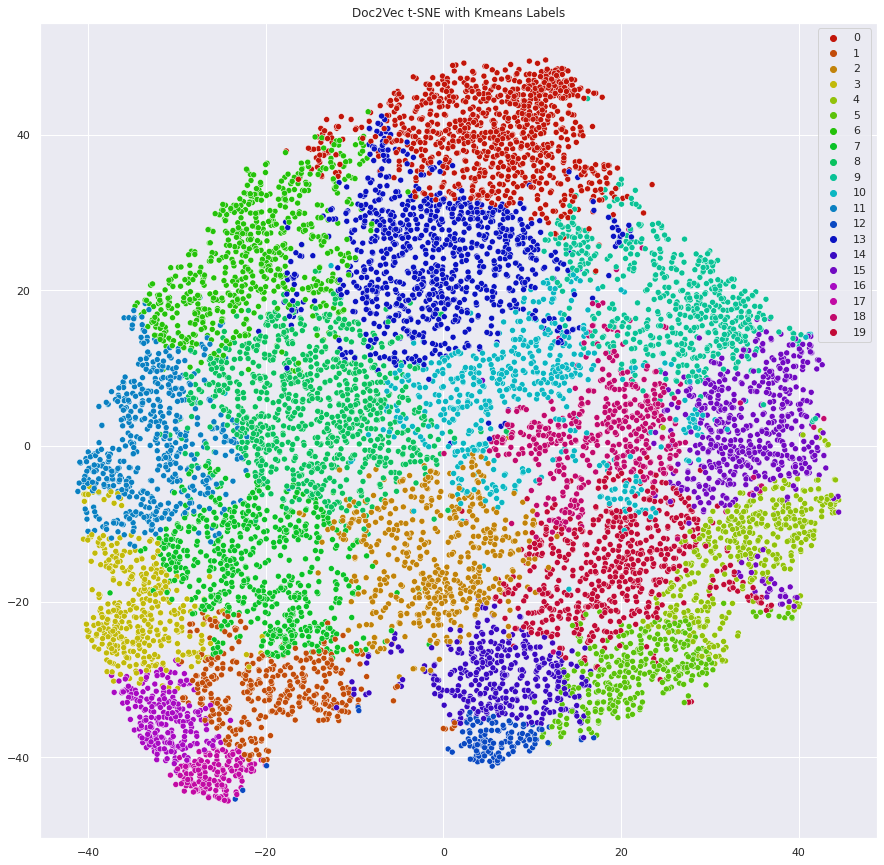

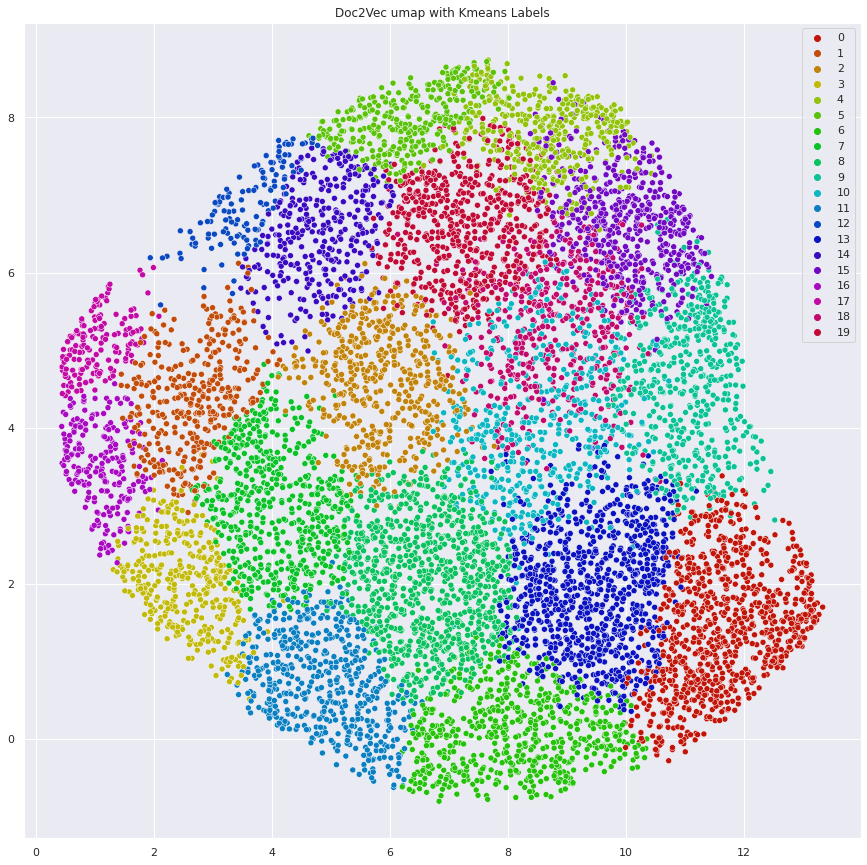

In [ ]:
clusterPlot(embeddings=doc2Vec_tsne, title="Doc2Vec t-SNE with Kmeans Labels", clusters=Doc2Vec_clusters, numClusters=20)
clusterPlot(embeddings=doc2Vec_umap, title="Doc2Vec umap with Kmeans Labels", clusters=Doc2Vec_clusters, numClusters=20)
interactiveClusterPlot(df= df_clustering, embeddings=doc2Vec_tsne, title="Doc2Vec Interactive t-SNE with Kmeans Labels", clusters=Doc2Vec_clusters)

### Doc2Vec Co-Citation

In [ ]:
doc2vec_test_embeddings = doc2vec_embeddings[test_indeces, :]
doc2vec_nneighbors = doNNeighbor(
      in_embeddings= doc2vec_embeddings, 
      sample_embeddings = doc2vec_test_embeddings, 
      n_neighbor=10, 
      printOutput=True
    )


======================== Nearest Neighbor ========================

Input shape: (115458, 512)

Output shape: (10, 10)

Output type: <class 'numpy.ndarray'>

Output: [[106548   9888  19817  81518   9532  89779  18283 113286 105895  44387]
 [ 84820  82352  17471  47579  11195  23928  51887  78858  89464  21616]
 [ 59730  14195  65044  50518  58110  23142  45952  69478  54690 110412]
 [ 88991  88665  61575  26154  90758 115139  64757  54863  57360  93135]
 [ 59523  15116  50263  47086   7011  43035  32533  87939  58557  60231]
 [110416  63158  36511  16110  79009   1977  64171  75173  32051  34617]
 [ 37813  32965  65939  56823  26812  15068  26545  61765  13624  28452]
 [ 33932  41293  42509  37639  13677  12080  37322  68824  32466  57913]
 [ 83151  82967  60843  32610  22922  17709 108255  32786  18497   6931]
 [ 67483  78976  18746  33313  69171  49571  16848  34581  39805   2714]]


In [ ]:
documents_with_tokens.iloc[doc2vec_nneighbors[0]]

level_0   index               id  \
106548   106548  969505   hep-th/9610251   
9888       9888   82663        0907.3193   
19817     19817  171109        1108.5045   
81518     81518  944469   hep-th/0009158   
9532       9532   79650        0906.3743   
89779     89779  952732   hep-th/0312145   
18283     18283  157643        1105.1599   
113286   113286  976582  math-ph/0201023   
105895   105895  968852   hep-th/9607058   
44387     44387  437134       1610.00011   

                                                  authors  \
106548  [Ganor Ori J., Morrison David R., Seiberg Nathan]   
9888                                [Kowalski-Glikman J.]   
19817                          [Mathai Varghese, Wu Siye]   
81518      [Gomis Joaquim, Kamimura Kiyoshi, Mateos Toni]   
9532                [Alexandrov Sergei, Saueressig Frank]   
89779         [Halmagyi Nick, Okuda Takuya, Yasnov Vadim]   
18283                    [Mercati Flavio, Sitarz Andrzej]   
113286                   [Bauer Claudia, Wachter Hartmut]   
105895                        [Antoniadis I., Pioline B.]   
44387                                    [Yang Hyun Seok]   

                                                    title  \
106548  Branes, Calabi-Yau Spaces, and Toroidal Compac...   
9888                              $\kappa$--Rindler space   
19817   Topology and Flux of T-Dual Manifolds with Cir...   
81518   Gauge and BRST Generators for Space-Time Non-c...   
9532                 Quantum mirror symmetry and twistors   
89779   Large N Duality, Lens Spaces and the Chern-Sim...   
18283   Kappa-Minkowski differential calculi and star ...   
113286         Operator Representations on Quantum Spaces   
105895  Higgs branch, HyperKahler quotient and duality...   
44387              Emergent Spacetime for Quantum Gravity   

                                  doi  \
106548  10.1016/S0550-3213(96)00690-6   
9888       10.1103/PhysRevD.80.044028   
19817       10.1007/s00220-012-1542-8   
81518   10.1088/1126-6708/2001/03/010   
9532    10.1088/1126-6708/2009/09/108   
89779   10.1088/1126-6708/2004/04/014   
18283             10.22323/1.127.0030   
113286     10.1140/epjc/s2003-01324-0   
105895      10.1142/S0217751X97002620   
44387       10.1142/S0218271816450103   

                                                 category  \
106548                                           [hep-th]   
9888                                             [hep-th]   
19817   [hep-th, math-ph, math.DG, math.GT, math.MP, m...   
81518                                            [hep-th]   
9532                                             [hep-th]   
89779                                            [hep-th]   
18283                          [math-ph, hep-th, math.MP]   
113286                         [math-ph, hep-th, math.MP]   
105895                                           [hep-th]   
44387                   [hep-th, gr-qc, math-ph, math.MP]   

                                                 abstract  \
106548    We consider compactifications of the N=1, d=...   
9888      In this paper we construct, and investigate ...   
19817     We present an explicit formula for the topol...   
81518     The Hamiltonian (gauge) symmetry generators ...   
9532      Using the twistor approach to hypermultiplet...   
89779     We demonsrate that the spectral curve of the...   
18283     We present the star-product algebra of the k...   
113286    In this article we present explicit formulae...   
105895    Low--energy limits of N=2 supersymmetric fie...   
44387     We emphasize that noncommutative (NC) spacet...   

                                           processed_text  \
106548  consider compactification n=1 d=6 e_8 theory t...   
9888    paper construct investigate thermal property n...   
19817   present explicit formula topology h-flux t-dua...   
81518   hamiltonian gauge symmetry generator non-local...   
9532    use twistor approach hypermultiplet modulus sp...   
89779   demonsrat

In [ ]:
doc2vec_nneighbors_dois = [documents_with_tokens.iloc[rec]['doi'].to_numpy() for rec in doc2vec_nneighbors]
doc2vec_scores = coCitationScores(doc2vec_nneighbors_dois, printOutput="True")

======================= 10.1016/S0550-3213(96)00690-6 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}
======================= 10.1088/1126-6708/2002/05/051 =======================
{'coCitationCount': 0, 'citedCount': 1, 'refCount': 0}
======================= 10.1103/PhysRevResearch.2.033317 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}
======================= 10.1103/PhysRevD.69.067703 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}
======================= 10.1007/JHEP12(2019)151 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}
======================= 10.1006/aphy.1999.5917 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}
======================= 10.1007/JHEP09(2015)005 =======================
{'coCitationCount': 1, 'citedCount': 0, 'refCount': 0}
======================= 10.1088/1475-7516/2015/04/021 =======================
{'coCitati

In [ ]:
doc2vec_cocitationScore, doc2vec_citedScore, doc2vec_refScore = averageScores(doc2vec_scores, printOutput = True)


==================== Recommender Scores (Averages) ====================
Co-citation Sum: 2
Co-citation Score: 0.2
Citation Sum: 2
Citation Score: 0.2
Reference Sum: 0
Reference Score: 0.0


In [ ]:
multiSampleCoCitations(doc2vec_embeddings, documents_with_tokens, sample_size = 30, num_neighbors = 30, printOutput=True, seed=420)


======================= 10.1007/BFb0105256 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1088/1361-6382/abf89c =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1140/epjc/s10052-017-4758-0 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.3842/SIGMA.2010.057 =======================
{'coCitationCount': 2, 'citedCount': 0, 'refCount': 0}

======================= 10.1143/PTP.107.211 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1016/0920-5632(95)00630-3 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1007/s40509-014-0021-7 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1007/JHEP11(2017)020 =======================
{'coCitationCount': 0, 'ci

(3.8333333333333335, 0.2, 0.03333333333333333)

## RoBERTa

In [6]:
#documents_with_tokens = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/documents_with_tokens.pickle")
documents_with_tokens_split = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/documents_with_tokens_split_hep_th.pickle")

In [ ]:
print("length of documents_with_tokens: " + str(len(documents_with_tokens_split)))
documents_with_tokens_split.iloc[0:1]

length of documents_with_tokens: 115458


level_0  index         id            authors  \
0        0      5  0704.0015  [Stahn Christian]   

                                               title  \
0  Fermionic superstring loop amplitudes in the p...   

                             doi  category  \
0  10.1088/1126-6708/2007/05/034  [hep-th]   

                                            abstract  \
0    The pure spinor formulation of the ten-dimen...   

                                      processed_text  \
0  pure spinor formulation ten-dimensional supers...   

                                        tokens_split  
0  [pure, spinor, formulation, ten-dimensional, s...

### Fine Tuning

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForMaskedLM.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

In [ ]:
dataset = Dataset.from_pandas(documents_with_tokens_split[["abstract"]])
dataset

Dataset({
    features: ['abstract'],
    num_rows: 115458
})

In [ ]:
with open('./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/abstracts_cs.LG.txt', 'a') as the_file:
    for abstract in dataset['abstract']:
      the_file.write(abstract+'\n')

In [ ]:
dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path='./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/abstracts_cs.LG.txt',
    block_size=512,
)

/usr/local/lib/python3.7/dist-packages/transformers/data/datasets/language_modeling.py:125: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [ ]:
class zeroMemTrainer(Trainer):
  def __init__(self, *args, **kwargs):
    super(zeroMemTrainer, self).__init__(*args, **kwargs)

  # https://huggingface.co/transformers/v3.0.2/_modules/transformers/trainer.html
  # Overide Huggingface implementation to rewrite files your deleteing so they take up 0 memeory
  def _rotate_checkpoints(self, use_mtime=False, output_dir=None) -> None:
      if self.args.save_total_limit is None or self.args.save_total_limit <= 0:
          return

      # Check if we should delete older checkpoint(s)
      checkpoints_sorted = self._sorted_checkpoints(use_mtime=use_mtime, output_dir=output_dir)
      if len(checkpoints_sorted) <= self.args.save_total_limit:
          return

      # If save_total_limit=1 with load_best_model_at_end=True, we could end up deleting the last checkpoint, which
      # we don't do to allow resuming.
      save_total_limit = self.args.save_total_limit
      if (
          self.state.best_model_checkpoint is not None
          and self.args.save_total_limit == 1
          and checkpoints_sorted[-1] != self.state.best_model_checkpoint
      ):
          save_total_limit = 2

      number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - save_total_limit)
      checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
      for checkpoint in checkpoints_to_be_deleted:
          logger.info(f"Deleting older checkpoint [{checkpoint}] due to args.save_total_limit")
          for root, dirs, files in os.walk(checkpoint):
            for name in files:
              open(os.path.join(root, name), 'w').close()
          shutil.rmtree(checkpoint)


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/CE/models/roberta-base/roberta-retrained-cs.LG",
    overwrite_output_dir=True,
    num_train_epochs=25,
    per_device_train_batch_size=48,
    save_steps=500,
    save_total_limit=2,
    seed=1
)

trainer = zeroMemTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset
)

In [ ]:
trainer.train()

trainer.save_model("/content/drive/MyDrive/Colab Notebooks/CE/models/roberta-base/roberta-retrained-hep-th")

In [ ]:
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/CE/models/roberta-base/roberta-retrained-hep-th/trained_model")

Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/CE/models/roberta-base/roberta-retrained-hep-th
Configuration saved in /content/drive/MyDrive/Colab Notebooks/CE/models/roberta-base/roberta-retrained-hep-th/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/CE/models/roberta-base/roberta-retrained-hep-th/pytorch_model.bin


### Extract Embeddings

In [ ]:
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
roberta_model = AutoModelForMaskedLM.from_pretrained("/content/drive/MyDrive/Colab Notebooks/CE/models/roberta-base/roberta-retrained-hep-th/trained_model")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
roberta_model.to(device)

In [ ]:
abstracts = documents_with_tokens_split["abstract"]

In [ ]:
from torch.utils.data import Dataset

class RobertaDataset(Dataset):

  def __init__(self, txt_list, tokenizer, max_length=512):

    self.tokenizer = tokenizer
    self.input_ids = []
    
    for txt in txt_list:

      encodings_dict = tokenizer(txt, truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx]

In [ ]:
roberta_dataset = RobertaDataset(abstracts, roberta_tokenizer, max_length=512)
roberta_single_dataloader = DataLoader(
            roberta_dataset, # The entire list of abstracts.
            sampler = SequentialSampler(roberta_dataset), # Pull out batches sequentially.
            batch_size = 1
        )

Here is where I outline 6 methods for extracting a document embedding from GPT-2. A batch size of 1 abstract is fed into the network and the hidden states are returned. From there we can do an infinite number of different token embeddings extraction methods. I chose 6:

* Output of first hidden layer/embedding layer is a tensor(batch size X number of embeddings X length of feature map). In this case that is (1 x 512 x768)
  1. Take the mean of each embedding resulting in a 1x512x1 document embedding.
  2. Take the mean of all embeddings resulting in 1x1x768 length document embedding.
* Take the mean of the last 4 hidden layers resulting in a (1x512x768) tesnor.
  3. Take the mean again of each mean embedding resulting in a 1x512x1 document embedding.
  4. Take the mean of all the embedding means resulting in 1x1x768 length document embedding.
* concatenate the last 4 hidden layers resulting in a (1 x 512 x 3072) tensor
  5. Take the average of each embedding resulting in a 1x512x1 document embedding.
  6. First perform pooling with kernel size 4, then take the mean of all concatenated embeddings resulting in 1x1x768 length document embedding.


So we see 3 methods for taking or combining hidden layer output and then 2 methods for extracing embeddings from each.

In [ ]:
#roberta_embeddings = [0] * len(roberta_single_dataloader)
roberta_l1mean_embeddings = [0] * len(roberta_single_dataloader) 
roberta_last4catpool_embeddings = [0] * len(roberta_single_dataloader)
roberta_last4catmean_embeddings = [0] * len(roberta_single_dataloader)

pool1d_768 = torch.nn.AvgPool1d(768)
pool1d_4 = torch.nn.AvgPool1d(4)
pool1d_4x768 = torch.nn.AvgPool1d(4*768)

for step, batch in enumerate(tqdm(roberta_single_dataloader)):
  
  b_input_ids = batch.to(device)

  with torch.no_grad():        
      outputs  = roberta_model(
          b_input_ids, 
          output_hidden_states=True
        )

      # ============== FIRST LAYER (TOKEN EMBEDDINGS POOLED INTO 1 DIMENSION) =====================
      ''' first_layer = outputs.hidden_states[0]
      roberta_embeddings[step] = pool1d_768(first_layer).view(512).cpu().numpy() '''

      # ============== FIRST LAYER (TOKEN EMBEDDINGS AVERAGED) =====================================
      first_layer = outputs.hidden_states[0]
      roberta_l1mean_embeddings[step] = torch.mean(first_layer, dim=1).view(768).cpu().numpy()




      # ============== LAST 4 LAYERS AVERAGED (TOKEN EMBEDDINGS POOLED INTO 1 DIMENSION) ===========
      ''' last_four_layer = torch.stack(list(outputs.hidden_states[-4:]), dim=0)
      mean_layer = torch.mean(last_four_layer, dim = 0)
      roberta_embeddings[step] = pool1d_768(mean_layer).view(512).cpu().numpy() '''

      # ============== LAST 4 LAYERS AVERAGED (TOKEN EMBEDDINGS AVERAGED) ==========================
      ''' last_four_layer = torch.stack(list(outputs.hidden_states[-4:]), dim=0)
      mean_layer = torch.mean(last_four_layer, dim = 0)
      roberta_embeddings[step] = torch.mean(mean_layer, dim=1).view(768).cpu().numpy() '''
      


      # ============== LAST 4 LAYERS CONCATENATED THEN 1D POOLIING INTO 1 DIMENSION ================
      last_four_layers = outputs.hidden_states[-4:]
      last_four_layers_cat = torch.cat(last_four_layers, dim=2)
      roberta_last4catpool_embeddings[step] = pool1d_4x768(last_four_layers_cat).view(512).cpu().numpy()
      
      # ============== LAST 4 LAYERS CONCATENATED THEN 1D POOLING THEN AVERAGED ====================
      #last_four_layers = outputs.hidden_states[-4:]
      last_four_layers_pooled = pool1d_4(torch.cat(last_four_layers, dim=2))
      roberta_last4catmean_embeddings[step] = torch.mean(last_four_layers_pooled, dim=1).view(768).cpu().numpy()




100%|██████████| 115458/115458 [55:43<00:00, 34.54it/s]


In [ ]:
#np.savez_compressed("/content/drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings_hep_th/roberta_l1pool_embeddings.npz", embedding=roberta_embeddings)
np.savez_compressed("/content/drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings_hep_th/roberta_l1mean_embeddings.npz", embedding=roberta_l1mean_embeddings)
np.savez_compressed("/content/drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings_hep_th/roberta_last4catpool_embeddings.npz", embedding=roberta_last4catpool_embeddings)
np.savez_compressed("/content/drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings_hep_th/roberta_last4catmean_embeddings.npz", embedding=roberta_last4catmean_embeddings)

### RoBERTa Co-Citation

In [ ]:
roberta_l1pool_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings_hep_th/roberta_l1pool_embeddings.npz", allow_pickle=True)["embedding"]
roberta_l1mean_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings_hep_th/roberta_l1mean_embeddings.npz", allow_pickle=True)["embedding"]
roberta_last4catpool_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings_hep_th/roberta_last4catpool_embeddings.npz", allow_pickle=True)["embedding"]
roberta_last4catmean_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings_hep_th/roberta_last4catmean_embeddings.npz", allow_pickle=True)["embedding"]

In [ ]:
multiSampleCoCitations(roberta_l1pool_embeddings, documents_with_tokens, sample_size = 30, num_neighbors = 30, printOutput=True, seed=420)


======================= 10.1007/BFb0105256 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1088/1361-6382/abf89c =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1140/epjc/s10052-017-4758-0 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.3842/SIGMA.2010.057 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1143/PTP.107.211 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1016/0920-5632(95)00630-3 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1007/s40509-014-0021-7 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1007/JHEP11(2017)020 =======================
{'coCitationCount': 0, 'ci

(0.0, 0.0, 0.0)

In [ ]:
multiSampleCoCitations(roberta_l1mean_embeddings, documents_with_tokens, sample_size = 30, num_neighbors = 30, printOutput=True, seed=420)


======================= 10.1007/BFb0105256 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1088/1361-6382/abf89c =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1140/epjc/s10052-017-4758-0 =======================
{'coCitationCount': 2, 'citedCount': 0, 'refCount': 1}

======================= 10.3842/SIGMA.2010.057 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1143/PTP.107.211 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1016/0920-5632(95)00630-3 =======================
{'coCitationCount': 1, 'citedCount': 0, 'refCount': 0}

======================= 10.1007/s40509-014-0021-7 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1007/JHEP11(2017)020 =======================
{'coCitationCount': 2, 'ci

(1.1333333333333333, 0.0, 0.03333333333333333)

In [ ]:
multiSampleCoCitations(roberta_last4catpool_embeddings, documents_with_tokens, sample_size = 30, num_neighbors = 30, printOutput=True, seed=420)


======================= 10.1007/BFb0105256 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1088/1361-6382/abf89c =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1140/epjc/s10052-017-4758-0 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.3842/SIGMA.2010.057 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1143/PTP.107.211 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1016/0920-5632(95)00630-3 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1007/s40509-014-0021-7 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1007/JHEP11(2017)020 =======================
{'coCitationCount': 0, 'ci

(0.0, 0.0, 0.0)

In [ ]:
multiSampleCoCitations(roberta_last4catmean_embeddings, documents_with_tokens, sample_size = 30, num_neighbors = 30, printOutput=True, seed=420)


======================= 10.1007/BFb0105256 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1088/1361-6382/abf89c =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1140/epjc/s10052-017-4758-0 =======================
{'coCitationCount': 2, 'citedCount': 0, 'refCount': 0}

======================= 10.3842/SIGMA.2010.057 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1143/PTP.107.211 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1016/0920-5632(95)00630-3 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1007/s40509-014-0021-7 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1007/JHEP11(2017)020 =======================
{'coCitationCount': 0, 'ci

(0.2, 0.0, 0.0)

## GPT-2 Embeddings

In [7]:
documents_with_tokens_split = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/documents_with_tokens_split_hep_th.pickle")

In [5]:
gpt2_l1pool_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/CE/data/hasDOI/embeddings_hep_th/gpt2_l1pool_embeddings.npz", allow_pickle=True)["embedding"]

In [21]:
multiSampleCoCitations(gpt2_l1pool_embeddings, documents_with_tokens_split, sample_size = 30, num_neighbors = 30, printOutput=True, seed=420)


======================= 10.1103/PhysRevD.89.081701 =======================
{'coCitationCount': 1, 'citedCount': 0, 'refCount': 0}

======================= 10.1016/j.physletb.2004.05.059 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1016/S0393-0440(97)00034-X =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1103/PhysRevD.91.121301 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1140/epjc/s10052-017-4630-2 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1142/S0218271805007863 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1016/j.physletb.2006.12.068 =======================
{'coCitationCount': 0, 'citedCount': 0, 'refCount': 0}

======================= 10.1142/S021827181101913X ==================

(0.6333333333333333, 0.03333333333333333, 0.0)